# 1. Imports

In [314]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

import os
import pathlib
import logging
from typing import Optional, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Custom utils for rasterio
from src.utils import get_byte_size
# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, UTM35N
# For loading geotiff data
import rioxarray as rxr
# For loading and manipulating vector data
import geopandas as gpd
# For performing geospatial analysis
import pylandstats as pls

# Initialise the logging:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Data loading

## 2.1 ESA CCI Landcover data and classes 

In [50]:
esa_cci_landcovers = {year: GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.tif"  
                      for year in tqdm(range(1992, 2016))}

# Check that paths indeed exist
for path in esa_cci_landcovers.values():
    assert os.path.exists(path)
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

  0%|          | 0/24 [00:00<?, ?it/s]

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


## 2.2 Chernobyl & Polesia ROI

In [14]:
rois = gpd.read_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson")

In [15]:
rois

,name,area (km2),geometry
0,bbox,44022.318370,"POLYGON ((28.40773 50.54449, 31.41977 50.54449..."
1,E+60,17608.538086,"POLYGON ((28.42221 51.16929, 28.42178 51.17077..."
2,E+30,12731.935189,"POLYGON ((28.84467 51.21708, 28.84425 51.21856..."
3,Chernobyl Exclusion Zone,2597.858793,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.26795 5...
4,Polesie Exclusion Zone,2216.675202,GEOMETRYCOLLECTION (MULTIPOLYGON (((29.46530 5...
5,Nuclear Plant,0.000000,POINT (30.10410 51.38974)


# 3. Data preparation

## 3.1 Reprojection of raster data to suitable CRS (UTM35)

In [30]:
def preprocess_landcover(year: int, 
                         roi: Optional[gpd.GeoDataFrame] = None, 
                         data_files: dict = esa_cci_landcovers,
                         target_crs: str = UTM35N,
                         meter_per_pixel: int = 300,
                         show_plot: bool = False):
    
    logging.info("Loading data")
    data_original = rxr.open_rasterio(data_files[year])
    
    logging.info("Reprojecting")
    data_reprojected = data_original.rio.reproject(target_crs, 
                                                  resolution=(meter_per_pixel, meter_per_pixel))
    
    # Show reprojection
    if show_plot:
        data_reprojected.plot()
        plt.show()
    
    x_res = abs(data_reprojected.x.data[-1] - data_reprojected.x.data[0]) / len(data_reprojected.x.data)
    y_res = abs(data_reprojected.y.data[-1] - data_reprojected.y.data[0]) / len(data_reprojected.y.data)
    
    return {"data": data_reprojected,
            "transform" : data_reprojected.rio.transform(),
            "crs": target_crs,
            "x_res": x_res,
            "y_res": y_res}

In [33]:
def processed_landcover_to_landscape(processed_landcover: dict, nodata: int = 0):
    return pls.Landscape(processed_landcover["data"].data.squeeze(),
                         res = (processed_landcover["x_res"], processed_landcover["y_res"]),
                         nodata = nodata, 
                         transform = processed_landcover["transform"])

## 3.2 Defining relevant masks

Conveniently done via pylandstats zonal analysis

# 4. Fragmentation metric, geospatial analysis

## 4.1 Load landscapes and zones into memory

In [90]:
logger.setLevel(logging.WARNING)

landscapes = {year: processed_landcover_to_landscape(preprocess_landcover(year))
              for year in tqdm(range(1992, 2016))}

  0%|          | 0/24 [00:00<?, ?it/s]

In [91]:
get_byte_size(landscapes)

'12 MB'

It is interesting to note that all landscapes loaded into memroy (without any metrics computed) have 12 MB. 
After computing all the metrics, we will see that the landscapes grow significantly in size (~factor 20) to 
about 200 MB

In [93]:
zonal_analysers = {year: pls.ZonalAnalysis(landscapes[year],
                       landscape_crs = UTM35N,
                       masks=rois.iloc[1:-1],
                       masks_index_col="name") 
                   for year in tqdm(range(1992,2016))}

  0%|          | 0/24 [00:00<?, ?it/s]

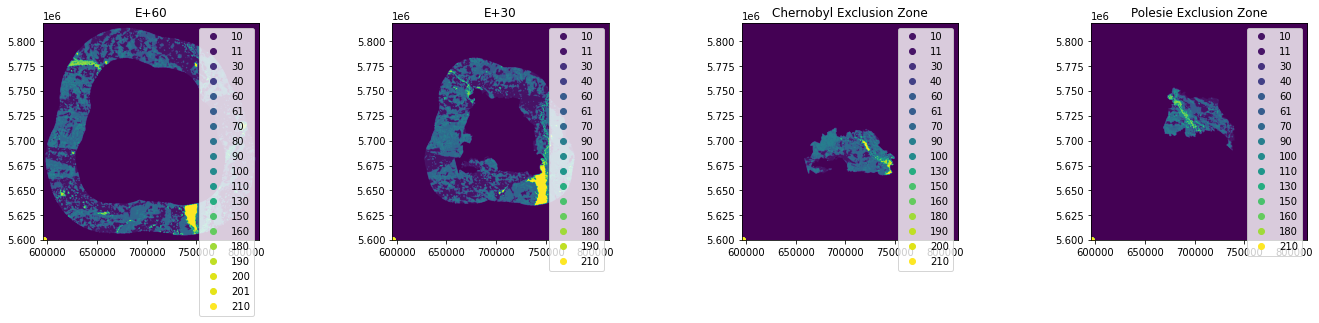

In [94]:
zonal_analysers[2015].plot_landscapes();

## 4.2 Perform computations

In [ ]:
# Perform zonal analysis for each yer
zonal_class_statistics = {}

for year, za in tqdm(zonal_analysers.items()):
    zonal_class_statistics[year] = za.compute_class_metrics_df()

In [98]:
get_byte_size(zonal_class_statistics)

'5 MB'

The zonal computation for 1992-2015 (on one JASMIN SCI 1 CPU) takes 30 min (not parallelized). Output dataframes take up 5MB in space.

In [129]:
# Save output of analysis
save_dir = GWS_DATA_DIR / "esa_cci_zonal_analysis"

save_dir.mkdir(mode=0o777, exist_ok=True)

for year, zonal_analysis_result in tqdm(zonal_class_statistics.items()):
    file_name = save_dir / f"esa_cci_{year}_zonal_analysis_class_statistics.csv"
    
    zonal_analysis_result.to_csv(file_name)
    file_name.chmod(0o664)  # to allow others to also read and write to these files
    
    

  0%|          | 0/24 [00:00<?, ?it/s]

## 5. Convert to Xarray and save

Turn results into Xarray for simplear analysis

In [401]:
# Define xarray axes
zones = rois.iloc[1:-1].name.tolist()
cci_classes = np.unique([index[0] for index in zonal_analysis_result.index])
metrics = zonal_analysis_result.columns.tolist()
years = np.arange(1992,2016, dtype=np.uint16)

# Reformat data into numpy array
raw_data = np.zeros((len(zones), len(cci_classes), len(metrics), len(years)))
for year_index, year in enumerate(years):
    result = zonal_class_statistics[year]
    for landcover_index, landcover in enumerate(cci_classes):
        raw_data[:, landcover_index, :, year_index] = result.loc[landcover].values

# Wrap numpy array into xarray data array object
data = xr.DataArray(raw_data, 
             coords = [zones, cci_classes, metrics, years],
             dims = ["zone", "cci_landcover_class", "metric", "year"])

# Save data to disk for further analysis
full_data_save_path = save_dir / "esa_cci_zonal_class_analysis_full_data.nc"

if not full_data_save_path.exists()
    data.to_netcdf(full_data_save_path)
    full_data_save_path.chmod(0o664)

In [403]:
data.loc[{"zone":"E+60", 
          "cci_landcover_class":10, 
          "metric": "effective_mesh_size"}]

<xarray.DataArray (year: 24)>
array([56275.09475968, 56265.15176492, 56233.08742106, 57320.6252588 ,
       56424.50344157, 57547.94882152, 57546.93171478, 52324.71690765,
       52241.99497844, 52028.38971913, 51766.64613224, 51482.04670324,
       49860.83947756, 49776.66039719, 49712.2776736 , 49648.77338749,
       49508.40912532, 49457.72796208, 49443.81576023, 49425.75426012,
       49420.59418538, 49387.15713962, 49336.7018472 , 49336.7018472 ])
Coordinates:
    zone                 <U24 'E+60'
    cci_landcover_class  int64 10
    metric               <U29 'effective_mesh_size'
  * year                 (year) uint16 1992 1993 1994 1995 ... 2013 2014 2015

In [393]:
def display_class_metric(zone: str, 
                         landcover_class: Union[int, str], 
                         metrics: str,
                         fig = None, 
                         **kwargs):
    
    '''Plot the temporal variation of class metrics for different class value'''
    # Input parsing        
    if isinstance(metrics, str):
        metrics = [metrics]
        
    if isinstance(landcover_class, str):
        # Deal with string labels
        assert landcover_class in classes.LCCOwnLabel.values
        landcover_class = classes[classes.LCCOwnLabel == landcover_class].index[0]
    
    # Create figure if necessary
    if not fig:
        plt.figure(figsize=(5,2))
        
    for metric in metrics:
        metric_name = metric.replace("_", " ").capitalize()
        class_name = classes.loc[landcover_class].LCCOwnLabel
        
        plot_title = f"{metric_name}: {class_name}({landcover_class})\n {zone}"
        
        plt.title(plot_title)
        
        plt.plot(data.year, 
                 data.loc[zone, landcover_class, metric, :],
                 linestyle="dashed",
                 marker=".")